## 備註：目前沒有對XGBoost進行調參。

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier

import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

np.set_printoptions(suppress=True)

In [2]:
yelpZip_preprocessed = pd.read_pickle('data/processed/yelpZip_preprocessed.pkl')

yelpZip_data = yelpZip_preprocessed.copy()
yelpZip_data.head()

,userId,prodId,date,content,content_len,label,rating,average_review_similarity,max_review_similarity,review_count_today,...,neg,neu,pos,compound,cap_word_count,digit_word_count,absolute_compound,length_deviation,review_count,extreme_rating_ratio
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0.000000,0.0000,1,...,0.513,0.487,0.000,-0.9287,0,0,0.9287,0.527778,1,0.0
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0.000000,0.0000,1,...,0.195,0.584,0.221,0.6128,0,2,0.6128,0.508065,1,0.0
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0.162733,0.3298,1,...,0.000,0.610,0.390,0.9153,1,0,0.9153,0.520000,4,0.0
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0.000000,0.0000,1,...,0.016,0.614,0.370,0.9954,1,0,0.9954,0.446352,1,0.0
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0.000000,0.0000,1,...,0.000,0.518,0.482,0.9945,0,0,0.9945,0.480263,1,0.0


# Experiment 1  - without text features

## Prepare dataset to feed into model

In [3]:
yelpZip_data['label'].replace(1, True, inplace=True)
yelpZip_data['label'].replace(-1, False, inplace=True)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

In [5]:
features = ['average_review_similarity', 'max_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len',
           'absolute_compound', 'cap_word_count', 'digit_word_count', 'length_deviation', 'review_count', 'extreme_rating_ratio']

x_train = x_train[features]
x_test = x_test[features]

## Train and Evaluate

### Experiment 1A. Without Oversampling

Training accuracy: 0.8750525799214807
Test accuracy: 0.8711863292803155

              precision    recall  f1-score   support

       False       0.61      0.08      0.14     20153
        True       0.88      0.99      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.74      0.53      0.53    152150
weighted avg       0.84      0.87      0.83    152150



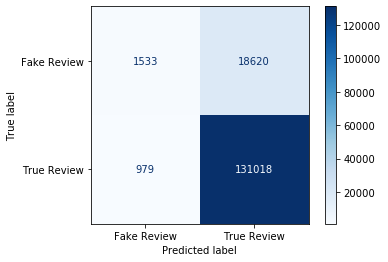

Complete in 0.0m 2.4732484817504883s


In [6]:
# Boosting
since = time.time()

classifier = XGBClassifier(
    eta=0.3, 
    min_child_weight=1,
    objective='binary:logistic', 
    tree_method='gpu_hist', gpu_id=0, 
    use_label_encoder=False, 
    eval_metric='logloss')
    # use_label_encoder=False: 標記沒有做讀熱編碼
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print(f'Training accuracy: {classifier.score(x_train, y_train)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [7]:
print('feature importances:')
for i in range(len(features)):
    print(f'{classifier.feature_importances_[i]:.7f} {features[i]}')

feature importances:
0.0756967 average_review_similarity
0.2839073 max_review_similarity
0.1136201 review_count_today
0.0652287 rating_deviation
0.0532465 tokenize_content_len
0.0200069 absolute_compound
0.0215541 cap_word_count
0.0142662 digit_word_count
0.0236310 length_deviation
0.2778826 review_count
0.0509598 extreme_rating_ratio


### Experiment 1B. With Oversampling

In [8]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 2.2426834106445312s


Training accuracy: 0.8279967687783205
Test accuracy: 0.7539533355241538

              precision    recall  f1-score   support

       False       0.31      0.68      0.42     20153
        True       0.94      0.76      0.84    131997

    accuracy                           0.75    152150
   macro avg       0.62      0.72      0.63    152150
weighted avg       0.86      0.75      0.79    152150



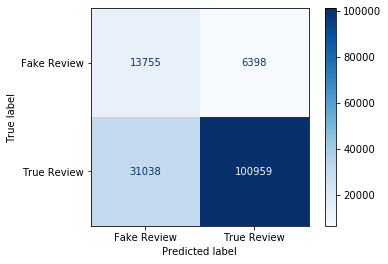

Complete in 0.0m 2.8740570545196533s


In [9]:
# Boosting
since = time.time()

classifier = XGBClassifier(
    eta=0.3, 
    min_child_weight=1,
    objective='binary:logistic', 
    tree_method='gpu_hist', gpu_id=0, 
    use_label_encoder=False, 
    eval_metric='logloss')
    # use_label_encoder=False: 標記沒有做讀熱編碼
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test, y_test)

print(f'Training accuracy: {classifier.score(x_train_oversampled, y_train_oversampled)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [10]:
print('feature importances:')
for i in range(len(features)):
    print(f'{classifier.feature_importances_[i]:.7f} {features[i]}')

feature importances:
0.0496814 average_review_similarity
0.0299670 max_review_similarity
0.0999333 review_count_today
0.0411135 rating_deviation
0.0545647 tokenize_content_len
0.0334898 absolute_compound
0.0423340 cap_word_count
0.0543404 digit_word_count
0.0687322 length_deviation
0.3884234 review_count
0.1374202 extreme_rating_ratio


# Experiment 2 - only text features

## Prepare dataset to feed into model

In [6]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

### 1. Transform corpus to vector

In [7]:
since = time.time()

vectorizer = CountVectorizer(max_features=15000)
vectorizer.fit(x_train['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 19.970421075820923s


In [8]:
since = time.time()

x_train = vectorizer.transform(x_train['corpus'])
x_test  = vectorizer.transform(x_test['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 25.90561318397522s


### 2. feature selection：chi-square

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pick_K = SelectKBest(chi2, k=150)
x_train_selected = pick_K.fit_transform(x_train, y_train)
print("x_train_selected shape:", x_train_selected.shape)

x_test_selected = pick_K.transform(x_test)  # transform不用Y，因為已經決定好要那些特徵了
print("x_test_selected shape:", x_test_selected.shape)

x_train_selected shape: (456448, 150)
x_test_selected shape: (152150, 150)


In [10]:
features_text = []
mask = pick_K.get_support()
for bool, feature in zip(mask, vectorizer.get_feature_names()):
    if bool:
        features_text.append(feature)

## Train and Evaluate

### Experiment 2A. Without Oversampling

Training accuracy: 0.8692490710880538
Test accuracy: 0.8674794610581663

              precision    recall  f1-score   support

       False       0.49      0.01      0.02     20153
        True       0.87      1.00      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.68      0.50      0.47    152150
weighted avg       0.82      0.87      0.81    152150



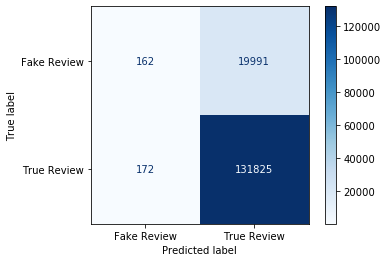

Complete in 0.0m 6.587561845779419s


In [11]:
# Boosting
since = time.time()

classifier = XGBClassifier(
    eta=0.3, 
    min_child_weight=1,
    objective='binary:logistic', 
    tree_method='gpu_hist', gpu_id=0, 
    use_label_encoder=False, 
    eval_metric='logloss')
    # use_label_encoder=False: 標記沒有做讀熱編碼
classifier.fit(x_train_selected, y_train)
score = classifier.score(x_test_selected, y_test)

print(f'Training accuracy: {classifier.score(x_train_selected, y_train)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test_selected)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test_selected, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [12]:
index = sorted(range(len(classifier.feature_importances_)), key=lambda k: classifier.feature_importances_[k])
fi_sort = sorted(classifier.feature_importances_)
for i in range(len(features_text)):
    print(f'{fi_sort[i]:.7f} {features_text[index[i]]}')

0.0020107 well
0.0020339 since
0.0020499 potato
0.0021078 big
0.0021353 one
0.0021457 tender
0.0022089 hot
0.0022168 green
0.0022254 portion
0.0022407 friend
0.0023040 lot
0.0023338 right
0.0023548 chicken
0.0023819 try
0.0023927 like
0.0024310 much
0.0024459 enough
0.0024542 fan
0.0024627 place
0.0024973 special
0.0025090 cream
0.0025146 menu
0.0025167 soft
0.0025635 french
0.0025775 sure
0.0025781 back
0.0025934 wait
0.0026131 around
0.0026238 roll
0.0026306 dessert
0.0026484 thing
0.0026502 bean
0.0026555 meal
0.0026743 burger
0.0026903 onion
0.0027103 would
0.0027114 two
0.0027253 bread
0.0027562 next
0.0027629 table
0.0028124 dish
0.0028238 salad
0.0028735 nice
0.0028775 taste
0.0029024 soup
0.0029748 texture
0.0030246 overall
0.0030579 bun
0.0030839 thats
0.0031076 bar
0.0031779 quite
0.0031857 bite
0.0031951 tomato
0.0033972 dont
0.0034958 red
0.0035696 rice
0.0036911 grilled
0.0037000 chocolate
0.0037071 plate
0.0037765 maybe
0.0037865 inside
0.0038183 get
0.0039220 roasted
0.0

### Experiment 2B. With Oversampling

In [13]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train_selected, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 1.0m 54.96210765838623s


Training accuracy: 0.8918247567117271
Test accuracy: 0.8381005586592178

              precision    recall  f1-score   support

       False       0.29      0.15      0.20     20153
        True       0.88      0.94      0.91    131997

    accuracy                           0.84    152150
   macro avg       0.58      0.55      0.55    152150
weighted avg       0.80      0.84      0.82    152150



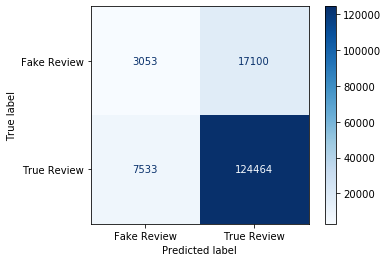

Complete in 0.0m 8.158648252487183s


In [14]:
# Boosting
since = time.time()

classifier = XGBClassifier(
    eta=0.3, 
    min_child_weight=1,
    objective='binary:logistic', 
    tree_method='gpu_hist', gpu_id=0, 
    use_label_encoder=False, 
    eval_metric='logloss')
    # use_label_encoder=False: 標記沒有做讀熱編碼
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test_selected, y_test)

print(f'Training accuracy: {classifier.score(x_train_oversampled, y_train_oversampled)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test_selected)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test_selected, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [15]:
index = sorted(range(len(classifier.feature_importances_)), key=lambda k: classifier.feature_importances_[k])
fi_sort = sorted(classifier.feature_importances_)
for i in range(len(features_text)):
    print(f'{fi_sort[i]:.7f} {features_text[index[i]]}')

0.0000000 creamy
0.0000000 green
0.0000000 light
0.0000000 onion
0.0000000 roasted
0.0000000 soft
0.0000000 tender
0.0000000 texture
0.0000000 tomato
0.0000968 bowl
0.0001195 slightly
0.0001373 belly
0.0001777 bean
0.0003779 bun
0.0006289 cream
0.0007351 chocolate
0.0007703 red
0.0008187 broth
0.0008826 waffle
0.0008994 worst
0.0009040 potato
0.0009945 bacon
0.0011795 bite
0.0011828 inside
0.0011896 maybe
0.0012205 horrible
0.0012427 french
0.0013698 salty
0.0013869 rude
0.0014111 manager
0.0014167 duck
0.0014992 grilled
0.0016602 mushroom
0.0018786 toast
0.0019850 liked
0.0019954 large
0.0020528 rice
0.0020558 fan
0.0021163 veggie
0.0021578 kind
0.0021616 flavorful
0.0021821 sausage
0.0022469 customer
0.0022739 crispy
0.0022770 beef
0.0022884 plate
0.0023023 quite
0.0024058 roll
0.0025022 owner
0.0025491 pancake
0.0025903 perfectly
0.0027203 hot
0.0027693 overall
0.0028046 there
0.0028491 white
0.0029052 bread
0.0030600 wasnt
0.0031484 thats
0.0031697 burger
0.0034699 big
0.0034981 co

# Experiment 3 - both text features & behavior features

## Prepare dataset to feed into model

In [16]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

### 1. Transform corpus to vector

In [17]:
since = time.time()

vectorizer = CountVectorizer(max_features=15000)
vectorizer.fit(x_train['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 20.173870086669922s


In [18]:
since = time.time()

x_train_text = vectorizer.transform(x_train['corpus'])
x_test_text  = vectorizer.transform(x_test['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 26.059004306793213s


### 2. feature selection：chi-square

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pick_K = SelectKBest(chi2, k=150)
x_train_selected = pick_K.fit_transform(x_train_text, y_train)
print("x_train_selected shape:", x_train_selected.shape)

x_test_selected = pick_K.transform(x_test_text)  # transform不用Y，因為已經決定好要那些特徵了
print("x_test_selected shape:", x_test_selected.shape)

x_train_selected shape: (456448, 150)
x_test_selected shape: (152150, 150)


In [20]:
features_text = []
mask = pick_K.get_support()
for bool, feature in zip(mask, vectorizer.get_feature_names()):
    if bool:
        features_text.append(feature)

### 3. Concat selected text features with other behavior features

In [21]:
features = ['average_review_similarity', 'max_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len',
           'absolute_compound', 'cap_word_count', 'digit_word_count', 'length_deviation', 'review_count', 'extreme_rating_ratio']

x_train = sp.sparse.hstack((x_train_selected, x_train[features].values))
x_test = sp.sparse.hstack((x_test_selected, x_test[features].values))

In [22]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (456448, 161)
x_test shape: (152150, 161)


In [23]:
features_all = features_text + features
print(len(features_all))
print(features_all[:5])

161
['also', 'around', 'back', 'bacon', 'bar']


## Train and Evaluate

### Experiment 3A. Without Oversampling

Training accuracy: 0.8765445351934941
Test accuracy: 0.8712980611238909

              precision    recall  f1-score   support

       False       0.59      0.09      0.16     20153
        True       0.88      0.99      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.73      0.54      0.55    152150
weighted avg       0.84      0.87      0.83    152150



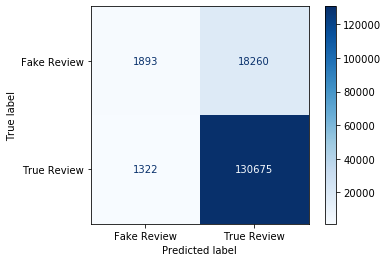

Complete in 0.0m 9.910545825958252s


In [24]:
# Boosting
since = time.time()

classifier = XGBClassifier(
    eta=0.3, 
    min_child_weight=1,
    objective='binary:logistic', 
    tree_method='gpu_hist', gpu_id=0, 
    use_label_encoder=False, 
    eval_metric='logloss')
    # use_label_encoder=False: 標記沒有做讀熱編碼
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print(f'Training accuracy: {classifier.score(x_train, y_train)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [25]:
index = sorted(range(len(classifier.feature_importances_)), key=lambda k: classifier.feature_importances_[k])
fi_sort = sorted(classifier.feature_importances_)
for i in range(len(features_all)):
    print(f'{fi_sort[i]:.7f} {features_all[index[i]]}')

0.0017802 inside
0.0023122 think
0.0023504 green
0.0023608 big
0.0024610 quite
0.0024805 potato
0.0025850 one
0.0026092 texture
0.0026453 thats
0.0027743 dish
0.0028096 much
0.0028202 chocolate
0.0028285 get
0.0028347 meal
0.0028524 like
0.0028894 also
0.0029096 bite
0.0029364 well
0.0029441 hot
0.0029776 would
0.0030039 special
0.0030077 meat
0.0030126 kind
0.0030230 mushroom
0.0030284 bean
0.0030361 good
0.0030379 liked
0.0031387 back
0.0031460 since
0.0031615 space
0.0031622 happy
0.0032045 chicken
0.0032478 french
0.0032569 digit_word_count
0.0032665 overall
0.0032668 slightly
0.0032692 still
0.0032773 lot
0.0032916 large
0.0033027 bar
0.0033347 cream
0.0033424 salad
0.0033446 right
0.0033459 really
0.0033549 dessert
0.0033704 wait
0.0033897 dont
0.0033934 grilled
0.0034298 friend
0.0034537 beer
0.0034976 maybe
0.0035190 enough
0.0035291 sure
0.0035296 soft
0.0035437 menu
0.0035543 thing
0.0035668 huge
0.0035752 nice
0.0036427 ill
0.0036731 around
0.0037093 try
0.0037135 portion
0.

### Experiment 3B. With Oversampling

In [26]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 3.0m 0.801098108291626s


Training accuracy: 0.5281520188824517
Test accuracy: 0.22776207689779823

              precision    recall  f1-score   support

       False       0.14      0.90      0.24     20153
        True       0.89      0.13      0.22    131997

    accuracy                           0.23    152150
   macro avg       0.51      0.51      0.23    152150
weighted avg       0.79      0.23      0.22    152150



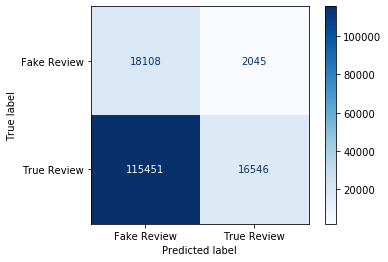

Complete in 0.0m 11.858301639556885s


In [27]:
# Boosting
since = time.time()

classifier = XGBClassifier(
    eta=0.3, 
    min_child_weight=1,
    objective='binary:logistic', 
    tree_method='gpu_hist', gpu_id=0, 
    use_label_encoder=False, 
    eval_metric='logloss')
    # use_label_encoder=False: 標記沒有做讀熱編碼
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test, y_test)

print(f'Training accuracy: {classifier.score(x_train_oversampled, y_train_oversampled)}')
print(f'Test accuracy: {score}\n')

predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

In [28]:
index = sorted(range(len(classifier.feature_importances_)), key=lambda k: classifier.feature_importances_[k])
fi_sort = sorted(classifier.feature_importances_)
for i in range(len(features_all)):
    print(f'{fi_sort[i]:.7f} {features_all[index[i]]}')

0.0000000 around
0.0000000 bacon
0.0000000 bar
0.0000000 bean
0.0000000 beef
0.0000000 belly
0.0000000 big
0.0000000 bit
0.0000000 bite
0.0000000 bowl
0.0000000 bread
0.0000000 broth
0.0000000 brunch
0.0000000 burger
0.0000000 cheese
0.0000000 chocolate
0.0000000 corn
0.0000000 cream
0.0000000 creamy
0.0000000 crispy
0.0000000 customer
0.0000000 duck
0.0000000 dumpling
0.0000000 egg
0.0000000 enough
0.0000000 fan
0.0000000 flavorful
0.0000000 french
0.0000000 fried
0.0000000 friend
0.0000000 fry
0.0000000 green
0.0000000 grilled
0.0000000 happy
0.0000000 id
0.0000000 ill
0.0000000 inside
0.0000000 kind
0.0000000 large
0.0000000 light
0.0000000 liked
0.0000000 line
0.0000000 little
0.0000000 lot
0.0000000 meal
0.0000000 meat
0.0000000 mushroom
0.0000000 onion
0.0000000 option
0.0000000 perfect
0.0000000 perfectly
0.0000000 plate
0.0000000 potato
0.0000000 ramen
0.0000000 red
0.0000000 roasted
0.0000000 roll
0.0000000 salad
0.0000000 salty
0.0000000 sandwich
0.0000000 sausage
0.0000000 s